# Neural & Behavioral Modeling - Week 6 (Exercises)
by 林子堯 (r08227112@ntu.edu.tw)

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
from IPython.display import *
from scipy.stats import *
from scipy.special import erfc
from tabulate import tabulate
import ipywidgets as widgets

## 1 Drift Diffusion Model (5 points)

Use whatever analytical methods to check if Tren's super EZ implementation(s) of the drift diffusion model produce exGaussian data, especially the exponential long tail. Remember to play around with different model parameters to see how they affect simulation results.

Hints:

[1] For parameter estimation of the ex-Gaussian distribution, you can use scipy.stats.exponnorm.fit().

[2a] You can compare two distributions by Q-Q plots or the Kolmogorov–Smirnov test

[2b] Alternatively, you can compare AIC/BIC to answer whether Exponential, Gaussian, or ex-Gaussian best fits Tren's data.

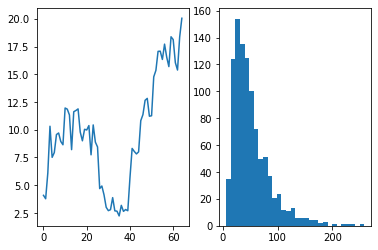

In [2]:
# Tren's implementation

random.seed(6666)

mu,sigma=0.2,2 # Diffusion type1
p=0.4 # Diffusion type2
Yend=20 # Threshold for response
Ntrial=1000

RTs=zeros(Ntrial)
for i in range(Ntrial):
    Y=0 # initial drift position
    Ys=[] # drift history
    RT=0 # Reset watch
    while(Y<Yend):
        dY=mu+random.normal(mu,sigma); # type1
        #dY=float((random.rand(1)-p)>0); # type2
        Y=Y+dY
        Ys.append(Y); # Diffusion history in each trial
        RT=RT+1 # clock is running
    RTs[i]=RT;
subplot(1,2,1);plot(Ys) # plot only the last trial to see the diffusion process
subplot(1,2,2);hist(RTs, bins = 30);

本次作業是要確認反應時間 (上方右圖) 中是否符合 exGaussian distribution。首先，依照老師作業中的提示 1 使用 `scipy.stats.exponnorm.fit()`，它是使用 MLE 的方式來估計 exGaussian 中的三個參數：shape ($K$), location ($\mu$) & scale ($\sigma$)。其中需要注意的是，Wiki 對 [exGaussian distribution](https://en.wikipedia.org/wiki/Exponentially_modified_Gaussian_distribution) 參數化模式為
$$
f(x; \mu, \sigma, \lambda) = \frac{\lambda}{2}e^{\frac{\lambda}{2}(2\mu + \lambda \sigma^2 - 2x)}\text{erfc}(\frac{\mu + \lambda \sigma^2 - x}{\sqrt{2}\sigma})
$$
與 `scipy.stats.exponnorm.fit()` 不相同，其中 rate ($\lambda = \frac{1}{K\sigma}$) 需要轉換一下。

另一方面，本題中還想要檢驗是否可以用 exponential distribution 或 normal distribution 來擬合 RTs，並且比較用何種分配究竟誰表現較好？其中 exponential distribution 的 pdf 為
$$
f(x; \lambda, \mu) = \lambda e^{-\lambda (x-\mu)}
$$
其中 $mu$ 為 location 參數和 $\lambda$ 為 rate 參數。同樣需要注意的一點是，如果我們用 `scipy.stats.expon.fit()` 來進行分配的參數估計的話，從中得到 scale 參數其實是上述 rate 參數的倒數。最後 normal distribution (Gauss distribuiton) 的 pdf 即為
$$
f(x; \mu, \sigma) = \frac{1}{\sqrt{2*\pi}\sigma}e^{\frac{(x-\mu)^2}{2\sigma^2}}
$$
我們一樣也能使用 `scipy.stats.norm.fit()` 來得道 $\mu \; \& \; \sigma$ 的估計。

在此，我先建立下文中任何所需的要的自訂 function，包括：

- exGauss, exponential and normal 各自 pdf 的計算；
- RTs 與 fitted distribution 對應圖與 Q-Q plot；
- Kolmogorov-Smirnov test；以及
- 計算模型診斷指標：AIC & BIC。

In [3]:
def dExGauss(x, mu, sigma, lmbd): # get probability density funcion of exGaussion
    exGauss = lmbd/2*exp(lmbd/2*(2*mu+lmbd*sigma**2-2*x))*erfc((mu+lmbd*sigma**2-x)/(sqrt(2)*sigma))
    return(exGauss)

def dEx(x, mu, lmbd):
    ex = lmbd*exp(-lmbd*(x-mu))
    return(ex)

def dNormal(x, mu, sigma):
    normal = 1/sqrt(2*pi*sigma**2)*exp(-((x-mu)/sigma)**2/2)
    return(normal)

def doKsTest(data, distName, parameters):
    statistic, pvalue = kstest(data, cdf = distName, args = parameters)
    print("======= Kolmogorov–Smirnov test =======")
    print("H0: RTs ~ %s(%s)" % (distName, around(parameters,3)))
    print("p-value = %.3f" % (pvalue))
    if pvalue < 0.05:
        print("Reject H0. \nRTs does not distribute form %s(%s)" \
              % (distName, around(parameters,3)))
    else:
        print("Fail to reject H0. \nWe can't reject that RTs does not distribute form %s(%s)" \
              % (distName, around(parameters,3)))
    print("=======================================")

def getFitPlot(data, distName, parameters):
    x = arange(0, data.max(), 0.05)
    
    if distName == "exponnorm": # exGauss parameters = (shape, loc, scale)
        density = dExGauss(x, mu = parameters[1], sigma = parameters[2], lmbd = 1/(parameters[0]*parameters[2]))
    elif distName == "expon": # exponential parameters = (loc, scale)
        density = dEx(x, mu = parameters[0], lmbd = 1/parameters[1])
    elif distName == "norm": # normal parameters = (loc, scale)
        density = dNormal(x, mu = parameters[0], sigma = parameters[1])
    else:
        print("The 'distName = %s' is not defined!" % distName)

    rcParams["figure.figsize"] = (12, 8)
    ax1 = subplot(2,2,1)
    ax1.hist(RTs, bins = 30, density = True)
    ax1.plot(x, density)
    ax1.legend([distName,"Tren's RTs"])
    ax2 = subplot(2,2,2)
    res = probplot(RTs, sparams = parameters, dist = distName, plot = ax2)
    rcParams["figure.figsize"] = (6, 6)    

def getCriteria(data, distName, parameters):
    if distName == "exponnorm": # exGauss parameters = (shape, loc, scale)
        density = dExGauss(data, mu = parameters[1], sigma = parameters[2], lmbd = 1/(parameters[0]*parameters[2]))
    elif distName == "expon": # exponential parameters = (loc, scale)
        density = dEx(data, mu = parameters[0], lmbd = 1/parameters[1])
    elif distName == "norm": # normal parameters = (loc, scale)
        density = dNormal(data, mu = parameters[0], sigma = parameters[1])
    else:
        print("The 'distName = %s' is not defined!" % distName)
    l = sum(log(density))
    k = len(parameters)
    n = len(data)
    AIC = -2*l + 2*k
    BIC = -2*l + log(n)*k
    return(distName, k, l, AIC, BIC)


## Fitting result
### ExGauss distribution

======= Kolmogorov–Smirnov test =======
H0: RTs ~ exponnorm([ 6.552 16.534  5.434])
p-value = 0.061
Fail to reject H0. 
We can't reject that RTs does not distribute form exponnorm([ 6.552 16.534  5.434])


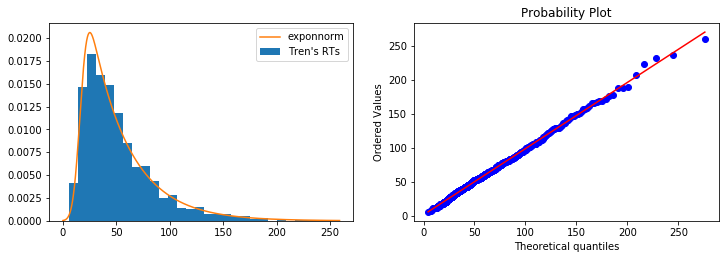

In [4]:
exGauss_pars = exponnorm.fit(RTs)
getFitPlot(RTs, "exponnorm", exGauss_pars)
doKsTest(RTs, "exponnorm", exGauss_pars)

使用 MLE 對參數估計下，我們可以看到 exGauss distrubution (exponnorm) 與 RTs 擬合得很好。使用 Q-Q plot 也沒有發現有什麼 RTs 的 quantile 與理論值有什麼太大的偏差，以及在 K-S test 中 ($\alpha = 
0.05$)，我們無法拒絕 RTs 不是符合 exGauss distrubution 這虛無假設。

不是符合### Exponential distribution

======= Kolmogorov–Smirnov test =======
H0: RTs ~ expon([ 6.    46.139])
p-value = 0.000
Reject H0. 
RTs does not distribute form expon([ 6.    46.139])


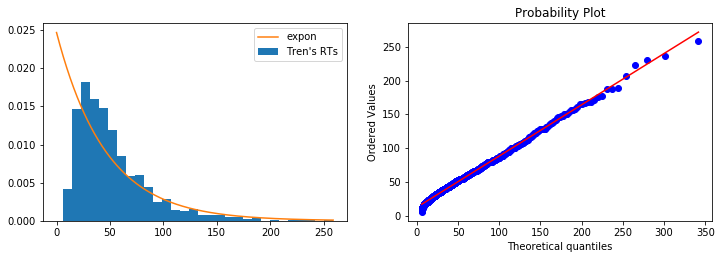

In [5]:
exponential_pars = expon.fit(RTs)
getFitPlot(RTs, "expon", exponential_pars)
doKsTest(RTs, "expon", exponential_pars)

若我們使用 exponential distribution (expon) 來擬合的話，在上方作圖中可觀察到 exponential distribution 確實可以描述到 RTs 右側的長尾，然而他卻無法描述在 RT 發生較小值的區域 (其發生頻率是較少的)。同樣的我們是用 Q-Q plot 來看，RTs 在較小值的區域與 exponential distribution 之理論值有蠻大的偏差。因此不易外的在 K-S test 中，我們得到顯著拒絕 RTs 使服從於 exponential distribution 的。


## Normal distribution

======= Kolmogorov–Smirnov test =======
H0: RTs ~ norm([ 6.    46.139])
p-value = 0.000
Reject H0. 
RTs does not distribute form norm([ 6.    46.139])


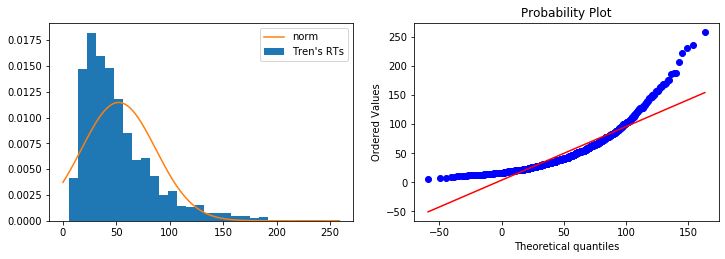

In [7]:
normal_pars = norm.fit(RTs)
getFitPlot(RTs, "norm", normal_pars)
doKsTest(RTs, "norm", exponential_pars)

若我們使用 normal distribution (norm) 來擬合的話，不管是本身 RTs 直方圖的長相或是在 Q-Q plot 來說都可以發現有明顯的偏差。舉理來說，normal distribution 是鐘型、對稱的分配，但 RTs 卻是不對稱的且有明顯的右尾。因此也很不易外的在 K-S test 中，我們得到顯著拒絕 RTs 使服從於 normal distribution 的。

## Model comparison

In [8]:
exponnorm_criteria = getCriteria(RTs, "exponnorm", exGauss_pars)
expon_criteria = getCriteria(RTs, "expon", exponential_pars)
norm_criteria = getCriteria(RTs, "norm", normal_pars)
table = tabulate([exponnorm_criteria, expon_criteria, norm_criteria], \
                 headers = ["model", "k", "loglikelihood", "AIC", "BIC"], \
                 tablefmt = 'orgtbl')
print(table)

| model     |   k |   loglikelihood |     AIC |     BIC |
|-----------+-----+-----------------+---------+---------|
| exponnorm |   3 |        -4704.89 | 9415.79 | 9430.51 |
| expon     |   2 |        -4831.66 | 9667.32 | 9677.13 |
| norm      |   2 |        -4967.24 | 9938.48 | 9948.3  |


最後，我們可以將三者進行模型的比較。由於 exponnorm distribution 有三個參數外，另外兩個則只有兩個，常理來說參數數較多的擬合的通常也會比較好 (likelihood 較高)。在此，我採用 AIC 與 BIC，同時考量模型的擬合程度與複雜度，作為模型表現的考量。結果來說，exGauss distribution 的 AIC 與 BIC 都是最低的，也就是說 exGaussion 比起其他分配來說較能描述此筆 RTs 資料的分配。 

## Change parameters of the drift model

In [9]:
def RT(mu, sigma, p, Yend):
    Ntrial=10000

    RTs=zeros(Ntrial)
    for i in range(Ntrial):
        Y=0 # initial drift position
        Ys=[] # drift history
        RT=0 # Reset watch
        while(Y<Yend):
            dY=mu+random.normal(mu,sigma); # type1
            #dY=float((random.rand(1)-p)>0); # type2
            Y=Y+dY
            Ys.append(Y); # Diffusion history in each trial
            RT=RT+1 # clock is running
        RTs[i]=RT;

    exGauss_pars = exponnorm.fit(RTs)
    print("\tloc(mu) = %.2f \n\tscale(sigma) = %.2f \n\tshape(K) = %.2f \n\trate(lambda) = %.2f" \
          % (exGauss_pars[1], exGauss_pars[2], exGauss_pars[0], 1/(exGauss_pars[0]*exGauss_pars[2])))
    x = arange(0, RTs.max(), 0.05)
    density = dExGauss(x, mu = exGauss_pars[1], sigma = exGauss_pars[2], lmbd = 1/(exGauss_pars[0]*exGauss_pars[2]))
    hist(RTs, bins = 30, density = True)
    plot(x, density)
    legend(["exGauss","Tren's RTs"])


In [10]:
widgets.interact(
    RT,
    mu = (0, 3, 0.25),
    sigma = (0.25, 10, 0.25),
    p = (0, 1, 0.05),
    Yend = (1, 50, 1)
)

interactive(children=(FloatSlider(value=1.0, description='mu', max=3.0, step=0.25), FloatSlider(value=5.0, des…

<function __main__.RT(mu, sigma, p, Yend)>

註：p 的拉桿可能需要將 `RT()` 裡的 Type 1 改為 Type 2，但下方觀察是依照 Type 1 的結果。

不在這邊我使用 widget，方便大家可以任意調整 mu, sigma 和 Yend 來觀察 RTs 整體分布情形。

透過上述觀察，可以下一些結論：

- 其實這三者皆會共同影響 exponential 估計 $\mu$、$\sigma$ 和 $\lambda$ 的值
- 當 `RT()` 中，每一步的步伐 mu 越大，或是抵達的邊際 Yend 越小，RT 的整體分布會往左邊偏移；
- mu 越大，RT 會越對稱；但 Yend 越小 右尾會更明顯；
- sigma 越大，RT 分散範圍會越廣 (會有明顯較大值出現)、越不對稱且有更明顯的右尾出現。

Please port the XOR simulation in 04_examples.ipynb from Matlab to Python

In [ ]:
### Write your codes here